**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 100

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.choose_colorbrewer_palette
#plt.style.use('seaborn')

%matplotlib inline

In [2]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

In [3]:
sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

In [4]:
grouped_data_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean().sort_values('lot')
grouped_data_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [5]:
response['lot'] = response['lot'].str.replace('lot', '').astype('int64')
response['class'] = response['class'].replace(['good', 'bad'], [1, 0]).astype('int64')
grouped_response = response.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [6]:
print(len(grouped_response.index) - len(grouped_data_25_to_56.index))
print(len(grouped_response.index) - len(grouped_data_1_to_24.index))
print(len(grouped_response.index))

0
348
1319


In [7]:
sensor_data = grouped_data_1_to_24.join(grouped_data_25_to_56, how='outer', lsuffix='_1_to_24', rsuffix='_25_to_56')
data = sensor_data.join(grouped_response, how='outer')

In [8]:
data = data.fillna(0)
print(len(grouped_response.index))

1319


In [9]:
data.sample(3);

In [10]:
data.info();

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   1319 non-null   float64
 1   sensor_1            1319 non-null   float64
 2   sensor_2            1319 non-null   float64
 3   sensor_3            1319 non-null   float64
 4   sensor_4            1319 non-null   float64
 5   sensor_5            1319 non-null   float64
 6   sensor_6            1319 non-null   float64
 7   sensor_7            1319 non-null   float64
 8   sensor_8            1319 non-null   float64
 9   sensor_9            1319 non-null   float64
 10  sensor_10           1319 non-null   float64
 11  sensor_11           1319 non-null   float64
 12  sensor_12           1319 non-null   float64
 13  sensor_13           1319 non-null   float64
 14  sensor_14           1319 non-null   float64
 15  sensor_15           1319 non-null   float64
 

In [11]:
data.describe();

In [12]:
data[['sensor_33']].value_counts()
zeros = (data['sensor_33'] == 0.0).sum()
total = data['sensor_33'].shape[0]
print(zeros * 100 / total)

bad_class_sum = (data['class']==0).sum()
good_class_sum = (data['class']==1).sum()
print(bad_class_sum * 100 / (bad_class_sum + good_class_sum))

99.92418498862774
20.015163002274452


Dropping sensor columns if more than 95% of the sensor values are 0.0

In [13]:
columns_before = data.columns;

In [14]:
data.head();

In [15]:
for n in data.columns:
    if ((data[n]==0).sum() * 100 / data[n].shape[0]) >= 95:
        data = data.drop(n, axis=1)

In [16]:
columns_after = data.columns;
print('Columns that were dropped for having < 95% of non zero values', set(columns_before) - set(columns_after))

Columns that were dropped for having < 95% of non zero values {'sensor_36', 'sensor_33', 'sensor_6'}


In [17]:
#ECDF plots
def ECDF(df_column):
    '''returns sorted data as x and proportionate 0.0 to 1.0 y values'''
    x = np.sort(df_column)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

#plt.style.use('seaborn')
#plt.set_cmap('gray')

#plt.figure(figsize=(50.0,50.0))
#for ax, n in list(enumerate(data.columns)):
#    x, y = ECDF(data[n])
#    plt.subplot(10, 10, ax+1)
#    plt.grid(True)
#    x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
#    plt.xlabel('%s readings' %n)
#    plt.yticks(np.arange(0, 1.1, 0.1))
#    plt.ylabel('ECDF')
#    plt.margins(0.02)

In [18]:
data[['sensor_12']].value_counts();
zeros = (data['sensor_12'] == 0.0).sum()
total = data['sensor_12'].shape[0]
print(zeros * 100 / total)

94.99620924943139


Well sensor 12 barely made the cut of having less than 95% of non zero values. Keeping sensor 12 column for now

In [19]:
lot_wafer_dict = dict(enumerate(data.index))

In [20]:
#data.set_index(list(lot_wafer_dict.keys()), inplace=True)
data['new_index'] = list(lot_wafer_dict.keys())
#data.set_index('new_index', inplace=True)

In [21]:
print(data.shape)
data.head()

(1319, 58)


timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
2   1                   87.5  5.231203  5.176705  13.251176  42.618787   
    2                   87.5  5.196315  5.142614  13.666808  43.419169   
    3                   87.5  5.161432  5.255114  13.243853  42.981363   
    4                   87.5  5.175509  5.294318  13.671360  43.151993   
    5                   87.5  5.201729  5.127273  13.332878  43.262745   

            sensor_5  sensor_7  sensor_8  sensor_9  sensor_10  sensor_11  \
lot wafer                                                                  
2   1      43.066761  8.505448       0.0  7.267045  11.703011  12.346591   
    2      43.147443  9.167583       0.0  7.607955  11.960227  12.761364   
    3      42.650795  8.666924       0.0  7.295455  11.563523  12.551136   
    4      42.904432  9.621476       0.0  7.613636  12.191591  13.215909   
    5      43.001705  9.275963       0.0  7.335227  11.556989  12.568182   

           sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  \
lot wafer                                                                     
2   1            0.0   0.266298   0.266298   0.266298   0.266298   6.164773   
    2            0.0   0.266162   0.266162   0.266162   0.266162   6.363636   
    3            0.0   0.266903   0.266903   0.266903   0.266903   6.164773   
    4            0.0   0.267062   0.267062   0.267062   0.267062   6.363636   
    5            0.0   0.266392   0.266392   0.266392   0.266392   6.204545   

            sensor_18   sensor_19  sensor_20  sensor_21   sensor_22  \
lot wafer                                                             
2   1      398.018165  126.723761   9.778409  79.217614  208.905500   
    2      408.363824  201.201568  10.329545  88.847159  208.953966   
    3      398.137699  113.195898   9.727273  79.772727  212.313545   
    4      408.062517  179.183085  10.164773  88.403409  212.313250   
    5      398.231636  107.544619   9.715909  80.952273  208.906159   

            sensor_23  sensor_24  timestamp_25_to_56  sensor_25   sensor_26  \
lot wafer                                                                     
2   1      467.232955   0.983864                87.5   0.001495  232.694903   
    2      467.204545   1.017557                87.5   0.001500  245.951321   
    3      477.465909   0.987557                87.5   0.001505  243.975941   
    4      477.437500   1.015966                87.5   0.001509  246.357599   
    5      467.227273   1.011364                87.5   0.001499  246.561347   

           sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  sensor_32  \
lot wafer                                                                     
2   1        60.1875     6.6875        0.0  21.821591  11.296246  79.692877   
    2        63.5625     7.0625        0.0  22.105284  10.849002  80.814970   
    3        63.0000     7.0000        0.0  21.821420  11.063067  80.783452   
    4        63.5625     7.0625        0.0  22.105057  10.858582  80.050300   
    5        63.5625     7.0625        0.0  22.104545  11.069689  80.733545   

           sensor_34  sensor_35  sensor_37  sensor_38  sensor_39   sensor_40  \
lot wafer                                                                      
2   1       0.001977  37.624962  21.595660  44.118530  42.609528  189.509110   
    2       0.001973  39.854000  22.763340  45.344954  43.932713  196.958829   
    3       0.001954  39.408217  22.018238  44.152238  43.927304  196.613328   
    4       0.001954  39.754566  21.757269  44.262521  41.514607  186.699584   
    5       0.001977  39.854118  22.053265  44.748803  43.069595  189.190050   

           sensor_41   sensor_42   sensor_43  sensor_44   sensor_45  \
lot wafer                                                             
2   1       1.660068  120.094154  122.751516   1.022727  690.483790   
    2       2.555232  126

In [22]:
## look into correlation mapping to see if one sensor is dependent on another
#plt.figure(figsize=(10,10))
#sns.heatmap(data.corr())
#print(data.corr()['sensor_55'].tail(10))
print(data.corr()['class'].sort_values().head())
print(data.corr()['response'].sort_values().head())

response    -0.896568
new_index   -0.105047
sensor_4    -0.103220
sensor_5    -0.103131
sensor_8    -0.081162
Name: class, dtype: float64
class       -0.896568
sensor_47   -0.316494
sensor_3    -0.300205
sensor_46   -0.260492
sensor_34   -0.259675
Name: response, dtype: float64


This is interesting, I expected response and class to both have the sensor with the highest correlation. Maybe the response threshold to classify class as good or bad (1 or 0) needs to be revisited. Per data author, threshold is set at 0.75 response units.

In [23]:
#X = data.drop('class', axis=1).astype('int64')
#y = data['class'].astype('int64')

X = data.drop('response', axis=1).astype('float')
y = data['response'].astype('float')

Logistic regression complains if the target value is continuous. This makes sense as logistic regression is a classification method. So for logistic regression use 'class' column as target.

In [24]:
data['response'].head();
print(X.shape)
print(y.shape)

(1319, 57)
(1319,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [26]:
#scaler = StandardScaler(with_mean=True)
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.transform(X_train);
scaler.transform(X_test);

In [27]:
#print(X_train.head())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(923, 57)
(923,)
(396, 57)
(396,)


In [28]:
lin_reg = LinearRegression()
log_reg = LogisticRegression(max_iter=100)
rand_for = RandomForestClassifier()
lasso_reg = Lasso(alpha=10)

In [29]:
lin_reg.fit(X_train, y_train)
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [30]:
#log_reg.fit(X_train, y_train)
#y_pred_train = log_reg.predict(X_train)
#y_pred_test = log_reg.predict(X_test)

In [31]:
#lasso_reg.fit(X_train, y_train)
#y_pred_train = lasso_reg.predict(X_train)
#y_pred_test = lasso_reg.predict(X_test)
#print(lasso_reg.coef_)

In [32]:
#rand_for.fit(X_train, y_train)
#y_pred_train = rand_for.predict(X_train)
#y_pred_test = rand_for.predict(X_test)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred_test.shape)

(923, 57)
(923,)
(396, 57)
(396,)
(396,)


In [34]:
y_test.head()

lot  wafer
47   1        0.4536
27   9        1.8396
74   2        0.3762
47   7        0.4626
65   4        0.3996
Name: response, dtype: float64

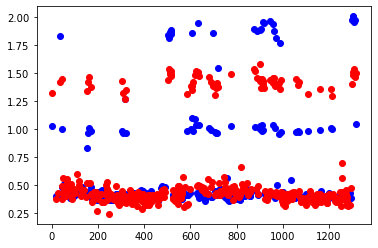

In [35]:
#plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.scatter(X_test['new_index'], y_test, c='blue')
plt.scatter(X_test['new_index'], y_pred_test, c='red')
#plt.figure(figsize=(20,3))
#plt.ylim(-0.5, 1.2)
#plt.scatter(np.arange(len(y_test)), y_test, c='green', s=15, alpha=0.4);
#plt.scatter(np.arange(len(y_test)), y_pred_test, c='red', s=15, alpha=0.2);
#plt.scatter(np.arange(len(y_train)), y_pred_train, c='red', s=15, alpha=0.2);

In [36]:
#X = X_pca
#pca = PCA(n_components=2)
#pca.fit(X_train)
#pca.transform(X_test)
#X_pca = pd.DataFrame(normalize(X_pca), columns=['PCA1', 'PCA2'])

In [37]:
#plt.scatter(y_test, y_pred_test, alpha=0.5)
#plt.figure(figsize=(20,3))
#plt.scatter(X_test['PCA1'], y_test, c='green', s=15, alpha=0.4);
#plt.scatter(X_test['PCA1'], y_pred_test, c='red', s=15, alpha=0.2);

In [38]:
#print(classification_report(y_test, y_pred_test, labels=[0,1]))
#print(classification_report(y_train, y_pred_train, labels=[0,1]))